In [1]:
import os
from glob import glob
from urllib.request import urlretrieve

import pandas as pd

In [2]:
url = 'https://docs.misoenergy.org/marketreports/PeakHourOverview_{}.csv'
# date strings look like this: 02072021

In [3]:
dates = pd.date_range(start='01-01-2019', end='02-07-2021')
date_strs = dates.strftime('%m%d%Y')

In [4]:
for d in date_strs:
    filename = 'miso/PeakHourOverview_{}.csv'.format(d)
    if not os.path.exists(filename):
        urlretrieve(url.format(d), filename)

Prototyping data cleaning and loading

In [5]:
df = pd.read_csv('miso/PeakHourOverview_{}.csv'.format(d))
df = df.iloc[:-2].T
df.columns = df.iloc[0]
df = pd.DataFrame(df.iloc[-1])
df.dropna(inplace=True)
df.T

Hourly Summary for 07-Feb-2021 (HE 20),(+) Committed + Available Short-Lead Generation,(+) NSI,(+) Behind-Meter Generation,Total Resources,(+) Forecasted Load,(+) Operating Reserve Requirement,Total Obligation,FORECASTED CAPACITY MARGIN
Unnamed: 1,104289,3156,1203,108648,86118,2410,88528,20120


In [6]:
csvs = glob('miso/*.csv')

In [7]:
dfs = []
for d, c in zip(date_strs, csvs):
    df = pd.read_csv('miso/PeakHourOverview_{}.csv'.format(d))
    df = df.iloc[:-2].T
    df.columns = df.iloc[0]
    df = pd.DataFrame(df.iloc[-1])
    df.dropna(inplace=True)
    df = df.T
    df.index = [pd.to_datetime(d, format='%m%d%Y')]
    dfs.append(df)

full_df = pd.concat(dfs)

In [8]:
full_df.shape

(769, 8)

In [9]:
full_df.head()

,(+) Committed + Available Short-Lead Generation,(+) NSI,(+) Behind-Meter Generation,Total Resources,(+) Forecasted Load,(+) Operating Reserve Requirement,Total Obligation,FORECASTED CAPACITY MARGIN
2019-01-01,101371,7900,914,110185,78664,2410,81074,29111
2019-01-02,111035,7540,910,119485,85092,2410,87502,31983
2019-01-03,114651,5735,929,121315,86508,2410,88918,32397
2019-01-04,108478,6649,961,116088,84147,2410,86557,29531
2019-01-05,104357,6114,820,111291,77116,2410,79526,31766


<AxesSubplot:>

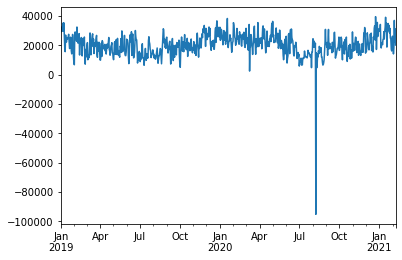

In [10]:
full_df['FORECASTED CAPACITY MARGIN'].plot()

It's very odd that there is a huge dip there. Investigating further...

In [11]:
full_df[full_df['FORECASTED CAPACITY MARGIN'] < 0]

,(+) Committed + Available Short-Lead Generation,(+) NSI,(+) Behind-Meter Generation,Total Resources,(+) Forecasted Load,(+) Operating Reserve Requirement,Total Obligation,FORECASTED CAPACITY MARGIN
2020-08-08,0,8069,929,8998,101805,2410,104215,-95218


Something must've went wrong that day, like a major power generator going offline. Or, there was a fatfinger typo in the data. Otherwise, it looks like the data roughly seasonally oscillates -- lower predicted margin the summer, higher in the winter. At this point, I'm not sure why this is.

<AxesSubplot:>

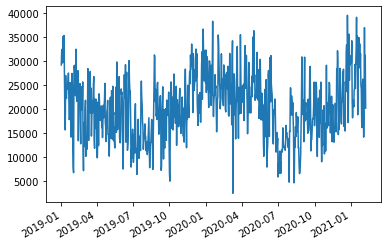

In [12]:
full_df[full_df['FORECASTED CAPACITY MARGIN'] > 0]['FORECASTED CAPACITY MARGIN'].plot()